# Práctica 1: Reconocimiento de dígitos manuscritos con extracción manual de características

El nuevo banco "First bank of Wiki" desea implementar un sistema de reconocimiento automático de cheques como el siguiente:

![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/b/b9/CanadianChequeSample.png)


Actualmente, el banco cuenta con un sistema capaz de aislar los dígitos y convertirlos en imágenes de 8 x 8, pero no de reconocer de qué dígito se trata. Por esa razón, nos ha solicitado realizar un módulo capaz de reconocer dígitos manuscritos dada una imagen de 8 x 8 pixeles:


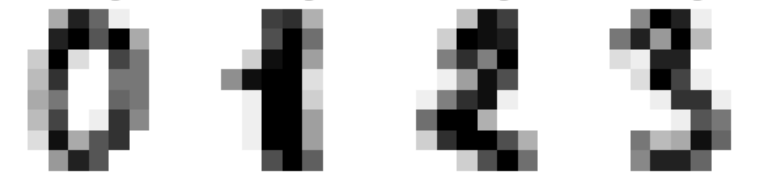



# Cargando los datos

Primero vamos a cargar el dataset y visualizar algunos dígitos.

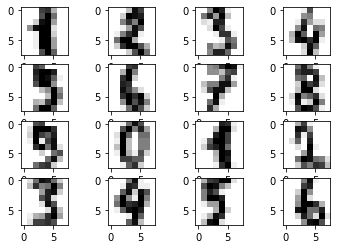

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.imshow(digits.images[i, :, :], cmap=plt.get_cmap("gray_r"))

# Binarizando el problema

Para comenzar con un problema más simple, sólo trabajaremos en el escenario de clasificación binaria para dígitos 0 y 1. Para eso, primero filtramos los datos y luego los particionamos en training y test folds.

In [2]:
# Cargo los dígitos
# X, y = load_digits(return_X_y=True)
X, y = digits.images, digits.target

# Filtro los que sean 0 o 1
indices = np.array(range(X.shape[0]))
bin_indices = indices[(y == 0) | (y == 1)]

X_bin = X[bin_indices, :, :]
y_bin = y[bin_indices]

# Creo los splits para training y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(
    X_bin, y_bin, test_size=0.33, random_state=42
)

print("Total de datos para clasificación entre 10 dígitos: " + str(y.shape[0]))
print("Total de datos para clasificación binaria: " + str(y_bin.shape[0]))
print("Total de 1s para clasificación binaria: " + str(y_bin_test.sum()))
print(
    "Total de 0s para clasificación binaria: "
    + str(y_bin_test.shape[0] - y_bin_test.sum())
)

Total de datos para clasificación entre 10 dígitos: 1797
Total de datos para clasificación binaria: 360
Total de 1s para clasificación binaria: 60
Total de 0s para clasificación binaria: 59


Visualizamos ahora los dígitos del problema binario

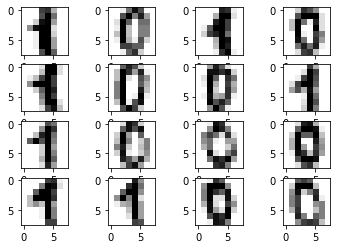

In [3]:
for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.imshow(X_bin[i, :, :], cmap=plt.get_cmap("gray_r"))

# Entrenando un perceptrón simple con extracción manual de características para clasificación binaria

Ahora procederemos a entrenar un perceptrón usando la biblioteca Scikit Learn. Esta biblioteca de aprendizaje automático implementa muchísimos modelos listos para usar. En este caso, usaremos el perceptrón simple `sklearn.linear_model.Perceptron`

Pero antes de definir el perceptrón, vamos a definir el método de extracción de características que transformará una imagen (`np.array`) de 8 x 8 en un vector unidimensional de 2 componentes. Para ello, podemos probar con dos estrategias diferentes (si se les ocurre alguna otra, adelante!):

* **Estrategia 1:** vamos a considerar la feature 0 como la media de intensidades de la parte superior del dígito (filas 0 a 3) y y la feature 1 como la media de la parte inferior (filas 4 a 7) tal como indica la imagen:

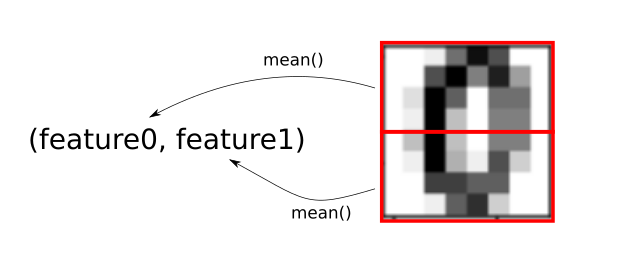

* **Estrategia 2:** Como alternativa, vamos a considerar la feature 0 como la media de toda la imagen, y la feature 1 como el desvío estandar:

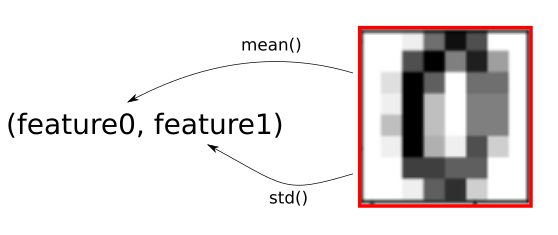


In [4]:
def extract_features_mean_std(x):
    x_out = np.zeros(shape=(1, 2))
    x_out[0, 0] = np.mean(x)
    x_out[0, 1] = np.std(x)

    return x_out


def extract_features_mean_top_bottom(x):
    x_out = np.zeros(shape=(1, 2))

    H, W = x.shape
    x_out[0, 0] = np.mean(x[: H // 2])
    x_out[0, 1] = np.mean(x[H // 2 :])

    return x_out


def preprocess_features_mean_std(X):
    X_pp = np.zeros(shape=(X.shape[0], 2))

    for i in range(X.shape[0]):
        X_pp[i, :] = extract_features_mean_std(X[i, :, :])

    return X_pp


def preprocess_features_mean_top_bottom(X):
    X_pp = np.zeros(shape=(X.shape[0], 2))

    for i in range(X.shape[0]):
        X_pp[i, :] = extract_features_mean_top_bottom(X[i, :, :])

    return X_pp

Ahora implementamos el perceptrón usando la clase `sklearn.linear_model.Perceptron` y lo entrenamos usando las features elegidas (probar con ambas features y ver cuál da mejor accuracy).

In [5]:
from sklearn.linear_model import Perceptron


def trainer(clf, X_train, y_train, X_test, y_test) -> None:
    """
    Entrena clasificador con X e y, e imprime resultados de ACC.
    """
    # Entrenamos el clasificador
    clf.fit(X_train, y_train)

    # Imprimir la accuracy en los datos de train.
    print("Accuracy en train: " + str(clf.score(X=X_train, y=y_train)))

    # Imprimir la accuracy en los datos de test.
    print("Accuracy en test: " + str(clf.score(X=X_test, y=y_test)))

    # Imprimir las predicciones realizadas para los datos de test
    print("Predictions: " + str(clf.predict(X_test)))

In [6]:
# Definimos un pereceptrón
clasificador = Perceptron(
    penalty="l2",
    n_jobs=-1,
    early_stopping=True,
)
# Transformamos las features de los datos para el problema binario
X_bin_train_mean_std = preprocess_features_mean_std(X_bin_train)
X_bin_test_mean_std = preprocess_features_mean_std(X_bin_test)
trainer(
    clasificador,
    X_train=X_bin_train_mean_std,
    y_train=y_bin_train,
    X_test=X_bin_test_mean_std,
    y_test=y_bin_test,
)

Accuracy en train: 0.8091286307053942
Accuracy en test: 0.7310924369747899
Predictions: [1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1
 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1
 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0
 1 1 1 1 0 1 1 1]


In [7]:
# Definimos un pereceptrón
clasificador = Perceptron(
    penalty="l2",
    n_jobs=-1,
    early_stopping=True,
)
# Transformamos las features de los datos para el problema binario
X_bin_train_top_bottom = preprocess_features_mean_top_bottom(X_bin_train)
X_bin_test_top_bottom = preprocess_features_mean_top_bottom(X_bin_test)
trainer(
    clasificador,
    X_train=X_bin_train_top_bottom,
    y_train=y_bin_train,
    X_test=X_bin_test_top_bottom,
    y_test=y_bin_test,
)

Accuracy en train: 0.5062240663900415
Accuracy en test: 0.5042016806722689
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


# Visualizando las features

Para entender el grado de discriminabilidad que presentan nuestras features, vamos a visualizarlas. Para hacerlo, colorear los items de cada clase con un color diferente.

In [8]:
import seaborn as sns

sns.set_theme()
# Show per group
def plot_features_2d(
    ax,
    features: np.array,
    label: np.array,
    labels_names: list,
) -> None:
    """
    ax: axes de matplotlib
    features: Features a mostrar. Shape=(n_samples, 2)
    """
    numeros = np.unique(label)
    for numero in numeros:
        ax.scatter(
            x=features[label == numero][:, 0],
            y=features[label == numero][:, 1],
            label=f"{numero}",
        )
    ax.legend()
    ax.set_title("Features")
    ax.set_xlabel(labels_names[0])
    ax.set_ylabel(labels_names[1])
    ax.grid(True)

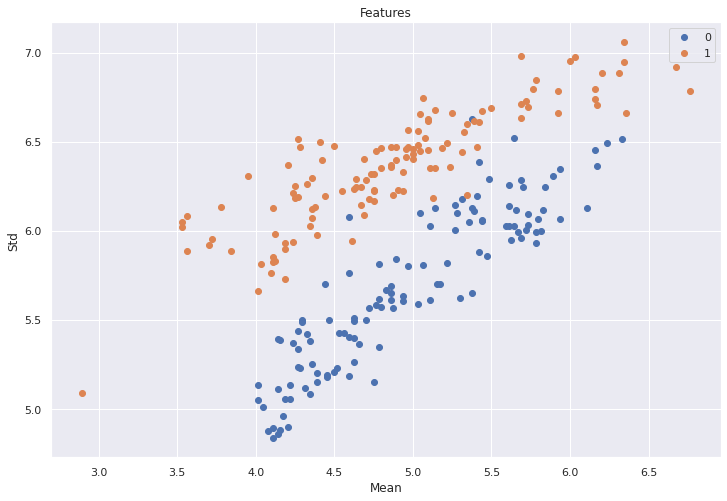

In [9]:
fig_features_binarias_1, ax = plt.subplots(1, figsize=(12, 8))
plot_features_2d(
    ax,
    features=X_bin_train_mean_std,
    label=y_bin_train,
    labels_names=["Mean", "Std"],
)

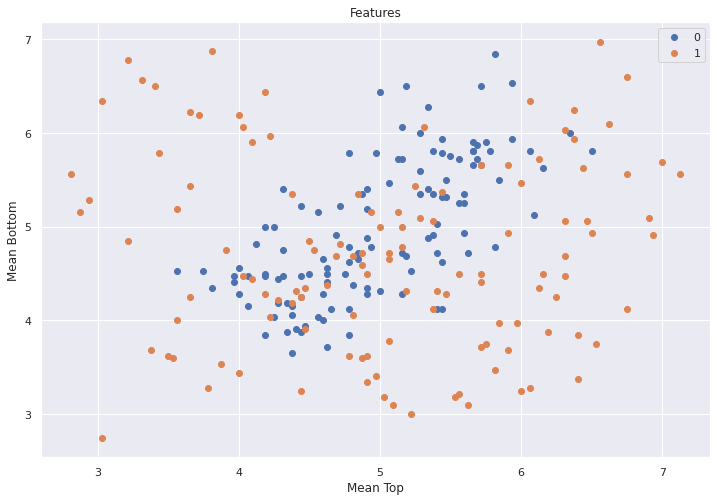

In [10]:
fig_features_binarias_2, ax = plt.subplots(1, figsize=(12, 8))
plot_features_2d(
    ax,
    features=X_bin_train_top_bottom,
    label=y_bin_train,
    labels_names=["Mean Top", "Mean Bottom"],
)

# Complicando las cosas: 


Ahora volvemos al caso de 10 dígitos y probamos la misma estrategia que estábamos usando anteriormente.

In [11]:
# Definimos un pereceptrón
clasificador10 = Perceptron(
    penalty="l2",
    n_jobs=-1,
    early_stopping=True,
)
# Transformamos las features de los datos para el problema multiclase
X_train_mean_std = preprocess_features_mean_std(X_train)
X_test_mean_std = preprocess_features_mean_std(X_test)
trainer(
    clasificador10,
    X_train=X_train_mean_std,
    y_train=y_train,
    X_test=X_test_mean_std,
    y_test=y_test,
)

Accuracy en train: 0.1862011637572735
Accuracy en test: 0.15488215488215487
Predictions: [0 0 1 0 1 1 0 1 1 3 1 0 0 0 0 3 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1
 0 1 0 3 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 3 0 0 0 0 1 0 3 0 0
 3 0 1 1 3 0 0 3 0 0 0 0 3 0 1 0 1 3 0 0 0 0 0 0 1 0 1 0 0 3 0 0 1 0 0 0 0
 1 3 3 0 0 1 0 0 0 0 0 3 1 0 1 0 0 0 0 0 1 1 1 0 0 0 3 0 0 0 0 1 3 0 0 1 3
 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 3 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 3 3 0 0 1 1 0 1 1 0 1 0 0 3 0 0 0 1 1 0 0 0 0 0 0 3 1 1 0 0 0 1 0 1
 0 1 0 0 1 0 3 1 0 1 0 0 1 1 0 0 0 1 0 0 1 3 0 0 1 0 0 3 0 0 1 0 3 3 0 0 1
 0 1 0 0 0 3 0 1 3 0 0 0 0 0 1 0 1 0 1 0 1 3 1 0 1 0 0 0 1 0 3 3 0 0 1 1 0
 0 0 3 0 0 0 3 3 1 0 0 0 0 3 0 0 0 1 0 1 0 3 1 1 0 0 0 1 0 0 0 0 0 0 0 0 3
 0 0 1 0 1 0 1 1 0 0 0 3 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0
 0 3 1 1 3 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 3 1 1 0 1 

In [12]:
# Definimos un pereceptrón
clasificador10 = Perceptron(
    penalty="l2",
    n_jobs=-1,
    early_stopping=True,
)
# Transformamos las features de los datos para el problema multiclase
X_train_top_bottom = preprocess_features_mean_top_bottom(X_train)
X_test_top_bottom = preprocess_features_mean_top_bottom(X_test)
trainer(
    clasificador10,
    X_train=X_train_top_bottom,
    y_train=y_train,
    X_test=X_test_top_bottom,
    y_test=y_test,
)

Accuracy en train: 0.12967581047381546
Accuracy en test: 0.11616161616161616
Predictions: [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 6 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0
 0 0 0 0 0 0 6 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 6 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0
 0 0 6 0 0

Para intentar entender por qué disminuye tan drásticamente la performance, visualicen las features de las 10 clases coloreando cada punto en un color diferente como hicimos anteriormente.

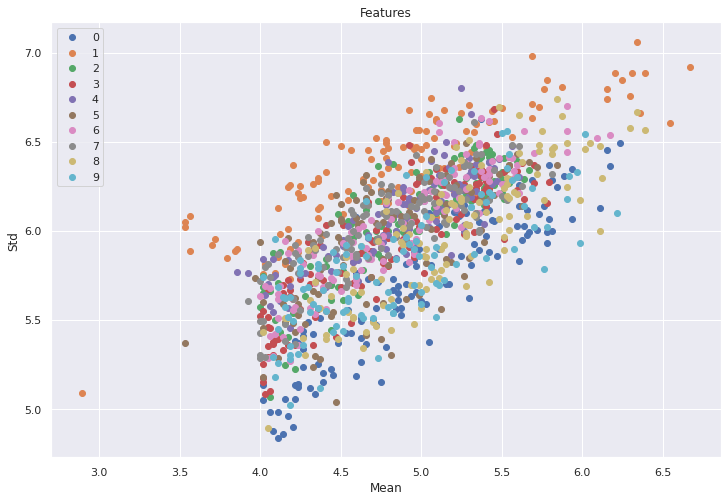

In [13]:
fig_features_multi_1, ax = plt.subplots(1, figsize=(12, 8))
plot_features_2d(
    ax,
    features=X_train_mean_std,
    label=y_train,
    labels_names=["Mean", "Std"],
)

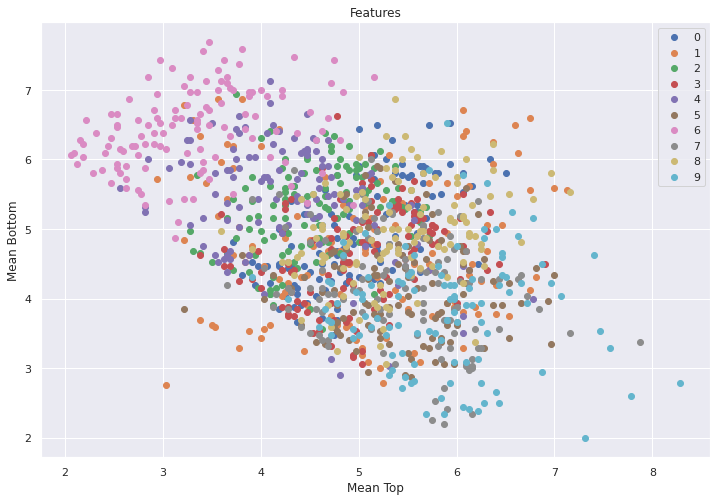

In [14]:
fig_features_multi_2, ax = plt.subplots(1, figsize=(12, 8))
plot_features_2d(
    ax,
    features=X_train_top_bottom,
    label=y_train,
    labels_names=["Mean Top", "Mean Bottom"],
)

# Entregable:
* Deberán entregar el Colab completo con el código funcionando. Además, deberán incluir (en el mismo Colab) un pequeño informe donde muestren las visualizaciones de las features, y responder a las siguientes preguntas:

1. ¿Cuál fue la estrategia de extracción de características que mejor te funcionó? Visualizar las features generadas por los extractores implementados y utilizarlas para explicar por qué funcionó mejor esa estrategia.

2. ¿Cuál sería la accuracy para un algoritmo que prediga aleatoriamente las clases en el caso del problema binario si los datos de test estuvieran balanceados? ¿Y en el caso del problema multiclase de 10 dígitos? 

3. El clasificador diseñado en cada caso (binario y multiclase), ¿Funcionó mejor que un clasificador aleatorio?



# Respuesta:



1. ¿Cuál fue la estrategia de extracción de características que mejor te funcionó? Visualizar las features generadas por los extractores implementados y utilizarlas para explicar por qué funcionó mejor esa estrategia.

En primer lugar, se debe saber que el perceptron es método de clasificación linear, por lo cual funcionara correctamente cuando las features de entrada sean linealmente separables (en el caso 2d, separables por una recta).
Por lo tanto, la utilidad de las features extraídas depende fuertemente de su separabilidad mediante una recta. En las siguientes celdas se observan las figuras para cada par de features, y para el caso binario.

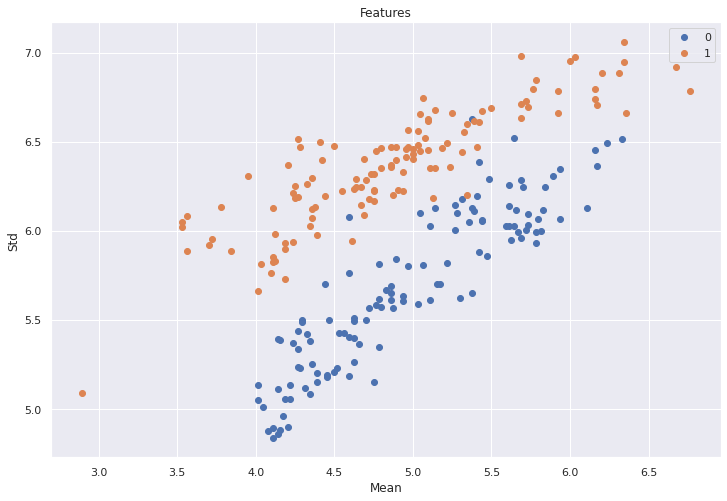

In [15]:
# Features de media y std
fig_features_binarias_1

En la figura anterior se aprecia como las features extraídas con mean y std de los números 0 y 1 parecen ser linealmente separables, mediante una recta diagonal.

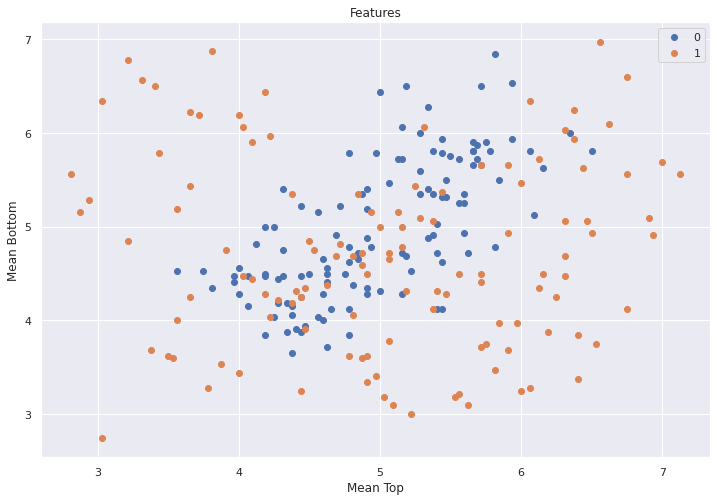

In [16]:
# features de media buttom y media top
fig_features_binarias_2

Para el otro par de features (mean bottom y mean top) de la figura anterior, no parece ser tan clara la separación mediante una recta.


Por el análisis anterior seria de esperar que las features de la primera figura tengan un rendimiento superior con un clasificador lineal como el perceptron en el caso binario.


Para el caso multiclase el análisis es análogo, solo que más difícil de visualizar porque hay 10 clases en una misma figura. Resulta más linealmente separable para la mean y std, mientras que para la media top_bottom las features parecen ser una nube de puntos con las 10 clases mezcladas sin un patrón aparente.


En la práctica, el análisis anterior se verifica, ya que la Mean y Std obtienen resultados de accuracy sobre train y test superiores.

2. ¿Cuál sería la accuracy para un algoritmo que prediga aleatoriamente las clases en el caso del problema binario si los datos de test estuvieran balanceados? ¿Y en el caso del problema multiclase de 10 dígitos? 


De modo genérico, si se tiene un modelo aleatorio, la accuracy sera 1 sobre la cantidad de clases. Por lo tanto, para le caso binario sera 50% y para 10 clases sera %10.


3. El clasificador diseñado en cada caso (binario y multiclase), ¿Funcionó mejor que un clasificador aleatorio?


Para el caso de la media top_bottom funciono levemente mejor en ambos casos, $50.4\%$ y $11.6\%$ sobre el conjunto de test para el caso binario y multiclase respectivamente. Por lo que se puede afirmar que estas features inducen a que el perceptron sea un clasificador casi aleatorio.


Mientras que para la media y std sobre toda la imagen supera los valores de un clasificador aleatorio, por lo que se puede afirmar que "aprendió". En particular para el caso binario logra valores en torno al $73.1\%$ sobre test (bastante superior al 50%), sabiendo distinguir 0's de 1's. Para el caso de 10 clases, el perceptron también es superior a aleatorio pero con menos margen, siendo su accuracy sobre test $15\%$. La caida de rendimiento para el caso multiclase se debe a que los otros números que no son 0 y 1 no son tan linealmente separables.